In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

base: str = "./datasets/"

In [2]:
# load transactions dataset
transactions = pd.read_csv(
    base + "transactions.csv",
    names=['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'],
    dtype={'timestamp': np.uint32, 'blockId': np.uint32, 'txId': np.uint32, 'isCoinbase': np.uint8},
)

# load input dataset
inputs = pd.read_csv(
    base + "inputs.csv",
    names=['txId', 'prevTxId', 'prevTxPos'],
    dtype={'txId': np.uint32, 'prevTxId': np.uint32, 'prevTxPos': np.uint16},
)

# load output dataset
outputs = pd.read_csv(
    base + "outputs.csv",
    names=['txId', 'txPos', 'addressId', 'amount', 'scriptType'],
    dtype={'txId': np.uint32, 'txPos': np.uint16, 'addressId': np.uint32, 'amount': np.uint64, 'scriptType': np.uint8}
)


# Script table/dict
scripts_dict = {0: 0, 1:153, 2:180, 3:291}

# Analisi fee rispetto a congestione


In [3]:
transactions_ncb = transactions[transactions['isCoinbase'] == 0].drop(columns=['blockId', 'isCoinbase'])

# Merge transactions with inputs; then calculate size of inputs
merged_tx_inputs = pd.merge(transactions_ncb, inputs.drop(columns=['prevTxId', 'prevTxPos']), on='txId', how='inner')
size_inputs = merged_tx_inputs.groupby('txId').size().reset_index(name='num_inputs')

# Merge transactions with outputs; then calculate size of outputs
merged_tx_outputs = pd.merge(transactions_ncb, outputs.drop(columns=['txPos', 'addressId']), on='txId', how='inner')
merged_tx_outputs['scriptSize'] = merged_tx_outputs['scriptType'].replace(scripts_dict)

size_outputs = merged_tx_outputs.groupby('txId').agg({'amount': 'count','scriptSize': 'sum'}).reset_index()
size_outputs.rename(columns={'amount': 'num_outputs'}, inplace=True)


In [8]:
# Merge the sizes with transactions
merged_transactions = pd.merge(transactions_ncb, size_inputs, on='txId', how='left')
merged_transactions = pd.merge(merged_transactions, size_outputs, on='txId', how='left')

INPUT_SIZE = 40
OUTPUT_SIZE = 9

# Calculate size of each transaction
merged_transactions['transaction_size'] = merged_transactions['num_inputs'] * INPUT_SIZE + merged_transactions['num_outputs'] * OUTPUT_SIZE + merged_transactions['scriptSize']
merged_transactions = merged_transactions.drop(columns=['num_inputs', 'num_outputs', 'scriptSize'])

#print(merged_transactions)

tt = merged_transactions.groupby('timestamp').agg({'fee': 'mean', 'transaction_size': 'sum'}).reset_index()
tt = tt.rename(columns={'fee': 'avgFee', 'transaction_size': 'congestion'})

#print(tt)

#print(transactions_ncb.nlargest(5, 'fee'))
#print(tt.nlargest(5, 'avgFee'))
print(tt.describe())

          timestamp        avgFee    congestion
count  1.306200e+05  1.306200e+05  1.306200e+05
mean   1.317988e+09  1.578124e+05  4.131758e+04
std    2.277982e+07  5.720015e+06  7.479096e+04
min    1.231731e+09  0.000000e+00  2.020000e+02
25%    1.300195e+09  0.000000e+00  2.977000e+03
50%    1.317297e+09  4.602909e+04  1.190450e+04
75%    1.337861e+09  9.470804e+04  4.654425e+04
max    1.356998e+09  1.718357e+09  2.464451e+06


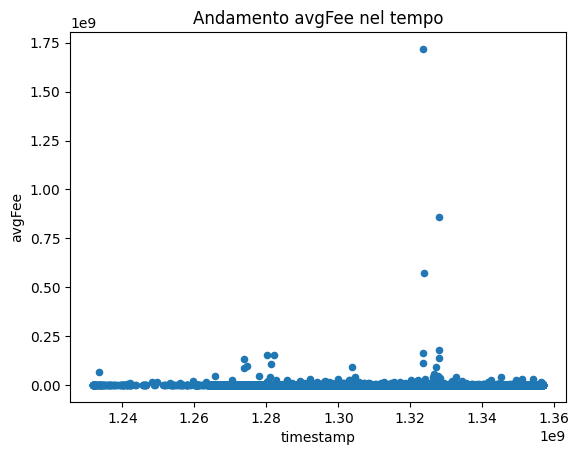

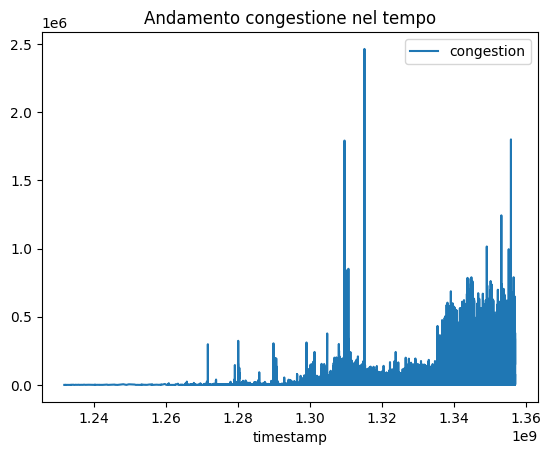

In [11]:
tt.plot.scatter(x='timestamp', y='avgFee', title='Andamento avgFee nel tempo')
tt.plot.line(x='timestamp', y='congestion', title='Andamento congestione nel tempo')
plt.show()

Come si nota dai grafici, nonostante nel tempo la congestione della blockchain sia aumentata di qualche ordine di grandezza, lo stesso non si può dire per la fee media. Nonostante alcuni outlier, generalmente è rimasta al di sotto del valore 0.25*10^E9

# Analisi script usati in transazioni

In [12]:
merged_tx_outputs = pd.merge(
    transactions.drop(columns=['blockId', 'fee', 'isCoinbase']), 
    outputs.drop(columns=['txPos', 'addressId', 'amount']), 
    on='txId', how='inner')

script_groups = merged_tx_outputs.pivot_table(index='timestamp', columns='scriptType', aggfunc='size', fill_value=0).reset_index()
script_groups.columns = ['timestamp', 'scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3']



#script_groups.set_index('timestamp')
script_groups['timestamp'] = pd.to_datetime(script_groups['timestamp'], unit='s')
print(script_groups.info())

# downsample df
print("\ndownsampling")
script_groups = script_groups.resample('1h', on='timestamp').sum().reset_index()
print(script_groups.info())
print(script_groups)



'''script_groups = script_groups.sample(n=10, random_state=46)
print(script_groups)

plt.bar(script_groups['timestamp'], script_groups['scriptType_1'], label='scriptType_1')
plt.bar(script_groups['timestamp'], script_groups['scriptType_3'], bottom=script_groups['scriptType_1'], label='scriptType_3')

plt.legend()
plt.show()'''




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214469 entries, 0 to 214468
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   timestamp     214469 non-null  datetime64[ns]
 1   scriptType_0  214469 non-null  int64         
 2   scriptType_1  214469 non-null  int64         
 3   scriptType_2  214469 non-null  int64         
 4   scriptType_3  214469 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 8.2 MB
None

downsampling
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34998 entries, 0 to 34997
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     34998 non-null  datetime64[ns]
 1   scriptType_0  34998 non-null  int64         
 2   scriptType_1  34998 non-null  int64         
 3   scriptType_2  34998 non-null  int64         
 4   scriptType_3  34998 non-null  int64         

"script_groups = script_groups.sample(n=10, random_state=46)\nprint(script_groups)\n\nplt.bar(script_groups['timestamp'], script_groups['scriptType_1'], label='scriptType_1')\nplt.bar(script_groups['timestamp'], script_groups['scriptType_3'], bottom=script_groups['scriptType_1'], label='scriptType_3')\n\nplt.legend()\nplt.show()"

In [ ]:
# Percentuali script

In [15]:
sc_pcg = script_groups
sc_pcg['total_count'] = sc_pcg[['scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3']].sum(axis=1)

# Calculate percentage of each script type
sc_pcg['scriptType_0_percent'] = (sc_pcg['scriptType_0'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_1_percent'] = (sc_pcg['scriptType_1'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_2_percent'] = (sc_pcg['scriptType_2'] / sc_pcg['total_count']) #* 100
sc_pcg['scriptType_3_percent'] = (sc_pcg['scriptType_3'] / sc_pcg['total_count']) #* 100

# Drop the total_count column
sc_pcg = sc_pcg.drop(columns=['total_count', 'scriptType_0', 'scriptType_1', 'scriptType_2', 'scriptType_3'])


#sc_pcg = sc_pcg.sample(n=1500, random_state=46)
#print(sc_pcg)

sc_pcg = sc_pcg.dropna()    # hours with no transactions will produce NaN => drop
#print(f'drop nan: {sc_pcg.info()}\n{sc_pcg}')

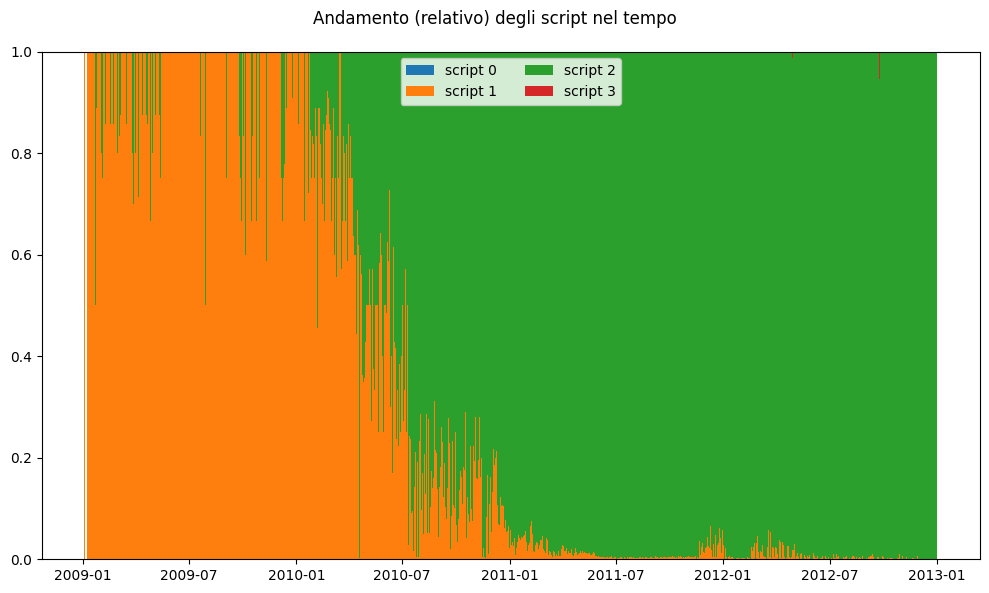

In [16]:
#plt.bar(sc_pcg['timestamp'], sc_pcg['scriptType_1_percent'], label='scriptType_1')
#plt.bar(sc_pcg['timestamp'], sc_pcg['scriptType_2_percent'], bottom=sc_pcg['scriptType_1_percent'], label='scriptType_2')

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_0_percent'], label='script 0')
ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_1_percent'], bottom=sc_pcg['scriptType_0_percent'], label='script 1')
ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_2_percent'], bottom=sc_pcg['scriptType_0_percent']+sc_pcg['scriptType_1_percent'], label='script 2')
ax.bar(sc_pcg['timestamp'], sc_pcg['scriptType_3_percent'], bottom=sc_pcg['scriptType_0_percent']+sc_pcg['scriptType_1_percent']+sc_pcg['scriptType_2_percent'], label='script 3')
#plt.xticks(rotation=45)

ax.legend(loc='upper center', ncol=2)
fig.suptitle("Andamento (relativo) degli script nel tempo")
plt.tight_layout()  # Adjust layout to prevent overlapping labels
#plt.savefig(fname='script_time.png')
plt.show()

Come si osserva dal grafico, inizialmente la quasi totalità delle transazioni usava lo script di tipo 1, ma a partire da metà 2010, c'è stato un enorme switch a favore del tipo 2.

Nei primi 3 anni, gli script di tipo 0 e 3 sono praticamente assenti. 

# Analisi delle Mining Pool

## Utils per scraping

In [18]:
import random
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from fake_useragent import UserAgent

In [21]:
# Funzione per estrazione dei proxy da sslproxies.org
def generate_proxies():
    ua = UserAgent() 
    
    proxies = []
    
    proxies_req = Request('https://www.sslproxies.org/')
    proxies_req.add_header('User-Agent', ua.random)
    proxies_doc = urlopen(proxies_req).read().decode('utf8')
    soup = BeautifulSoup(proxies_doc, 'html.parser')
    
    proxies_table = soup.find('table', class_='table table-striped table-bordered')
    
    # Salvo i proxy nella lista proxies
    for row in proxies_table.tbody.find_all('tr'):
        td = row.find_all('td')
        proxies.append(f'{td[0].string}:{td[1].string}')
    
    return proxies

In [20]:
def setup_driver(executable_path='/home/dan/Università/Info/3/LWS/progetto/geckodriver'):
    
    #rotate proxy ip
    proxies = generate_proxies()
    proxy_server_url = random.choice(proxies)
    
    options = Options()
    options.add_argument('--headless') #TODO: remove comment
    options.add_argument(f'--proxy-server={proxy_server_url}')
    options.add_argument(f'user-agent={UserAgent().random}')

    service = webdriver.FirefoxService(executable_path=executable_path)
    driver = webdriver.Firefox(service=service, options=options)

    return driver

In [ ]:
## Scraping degli indirizzi delle pool

In [23]:
import time
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException


URL = 'https://www.walletexplorer.com'
pools = ['Eligius', 'DeepBit', 'BitMinter', 'BTCGuild']

addresses = []

driver = setup_driver()
driver.get(URL)

for pool in pools:
    text_input = driver.find_element(By.XPATH, '/html/body/div[2]/form/p/label/input')
    search_button = driver.find_element(By.XPATH, '/html/body/div[2]/form/p/input')
    
    text_input.send_keys(pool)
    search_button.click()

    driver.implicitly_wait(5)
    viewAddress = driver.find_element(By.CSS_SELECTOR, '.showother > a:last-child')
    viewAddress.click()


    pages = driver\
        .find_element(By.XPATH, '/html/body/div[2]/div[1]')\
        .text.split(' ')
    
    totPages = int(pages[5])

    #TODO: more clean if going from last to first
    if totPages != 1:
        currentPage = 1

        while(currentPage < totPages):
            #print(f'curr: {currentPage}')
            
            # scrape addresses
            rows = driver.find_elements(By.TAG_NAME, 'tr')[1:]
            addresses += [{'pool': pool, 'address': row.find_element(By.XPATH, 'td[1]').text} for row in rows]
            
            # go to next page
            driver.implicitly_wait(5)
            try:
                nextButton = driver.find_element(By.XPATH, '//a[text()="Next…"]')
                nextButton.click()
            except NoSuchElementException:
                break

            currentPage += 1

        #print('out of while')
        driver.implicitly_wait(3)
        lastButton = driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/a[3]')
        lastButton.click()

        rows = driver.find_elements(By.TAG_NAME, 'tr')[1:]
        addresses += [{'pool': pool, 'address': row.find_element(By.XPATH, 'td[1]').text} for row in rows]


    time.sleep(5)

    homeAnchor = driver.find_element(By.XPATH, '/html/body/div[1]/h1/a')
    homeAnchor.click()

    #TODO: longer wait

driver.quit()

addressDf = pd.DataFrame.from_records(addresses, columns=['pool', 'address'])
addressDf.to_csv('poolAddresses.csv', index=False, header=False)


curr: 1
curr: 2
curr: 3
curr: 4
curr: 5
curr: 6
curr: 7
curr: 8
curr: 9
curr: 10
out of while
curr: 1
curr: 2
curr: 3
curr: 4
out of while
curr: 1
curr: 2
curr: 3
curr: 4
curr: 5
curr: 6
curr: 7
curr: 8
curr: 9
curr: 10
curr: 11
curr: 12
curr: 13
curr: 14
curr: 15
curr: 16
curr: 17
curr: 18
curr: 19
curr: 20
curr: 21
curr: 22
curr: 23
curr: 24
curr: 25
curr: 26
curr: 27
curr: 28
curr: 29
curr: 30
curr: 31
curr: 32
curr: 33
curr: 34
curr: 35
curr: 36
curr: 37
curr: 38
curr: 39
curr: 40
curr: 41
curr: 42
curr: 43
curr: 44
curr: 45
curr: 46
curr: 47
curr: 48
curr: 49
curr: 50
curr: 51
curr: 52
curr: 53
curr: 54
curr: 55
curr: 56
curr: 57
curr: 58
curr: 59
curr: 60
curr: 61
curr: 62
curr: 63
curr: 64
curr: 65
curr: 66
curr: 67
curr: 68
curr: 69
curr: 70
curr: 71
curr: 72
curr: 73
curr: 74
curr: 75
curr: 76
curr: 77
curr: 78
out of while


# Wallet scraping

In [28]:
from typing import Dict, TypeAlias

Address: TypeAlias = str
Wallet: TypeAlias = str


def get_wallet(addresses: list[Address]) -> Dict[Address, Wallet]:
    URL = 'https://www.walletexplorer.com'
    wallet = {}

    driver = setup_driver()
    driver.get(URL)

    for address in addresses:
        text_input = driver.find_element(By.XPATH, '/html/body/div[1]/form/input[1]')
        search_button = driver.find_element(By.XPATH, '/html/body/div[1]/form/input[2]')

        text_input.send_keys(address)
        search_button.click()

        driver.implicitly_wait(5)
        h2 = driver.find_element(By.XPATH, '/html/body/div[2]/h2')
        wallet_id = h2.text.split(' ')[1].replace('[', '').replace(']', '')
        
        wallet.update({address: wallet_id})

    driver.quit()
    return wallet

# Part 2

In [24]:
# load output dataset
mappings = pd.read_csv(
    base + "mappings.csv",
    names=['address', 'addressId'],
    dtype={'address': pd.StringDtype(), 'addressId': np.uint32}
)


# load pool dataset
pool = pd.read_csv(
    "poolAddresses.csv",
    names=['pool', 'address'],
    dtype={'pool': pd.StringDtype(), 'address': pd.StringDtype()}
)


transactions_cb = transactions[transactions['isCoinbase'] == 1]\
    .drop(columns=['isCoinbase', 'fee'])    # max fee == 0 => drop 'fee'

merged_tx_output = pd.merge(transactions_cb, outputs, on='txId')\
    .drop(columns=['txPos'])

In [25]:
# associate pool with address (better, id) of transactions 
merged_pool_id = pd.merge(pool, mappings, on='address')\
    .drop('address', axis=1)

assert merged_pool_id['addressId'].unique().size == len(merged_pool_id.index)   # assert no double (address <-> pool) relation

In [26]:
# de-anonymize
deanonymized_tx = pd.merge(merged_tx_output, merged_pool_id, on='addressId', how='left')
deanonymized_tx.fillna(value='Other', inplace=True)

#print(deanonymized_tx)

assert len(deanonymized_tx.index) == len(merged_tx_output.index)

In [29]:
#find top 4 miners
others = deanonymized_tx[deanonymized_tx['pool'] == 'Other']

#print(others)
#print(f'unique addresses: {others["addressId"].unique().size}')

addressTxCount = others.groupby('addressId').agg(txCount=('txId', 'size')).reset_index()
#print(addressTxCount.nlargest(4, 'txCount'))

assert len(addressTxCount.index) == others["addressId"].unique().size
assert addressTxCount['txCount'].sum() == len(others.index)

top4Miner = addressTxCount.nlargest(4, 'txCount')\
    .merge(mappings, on='addressId')\
    .drop(columns=['addressId'])

top4MinerAddresses = top4Miner['address'].to_numpy()
#print(list(top4MinerAddresses))

addr_wallets = get_wallet(list(top4MinerAddresses))

# convert address to addressId
id_wallets = {}

for addr, wallet in addr_wallets.items():
    id = mappings[mappings['address'] == addr]
    id_wallets.update({id['addressId'].values[0]: wallet})


# update deanonymized_tx with top4 miner wallet
def update_pool(row):
    if row['addressId'] in id_wallets:
        return id_wallets[row['addressId']]
    else:
        return row['pool']

deanonymized_tx['pool'] = deanonymized_tx.apply(update_pool, axis=1)

                pool  blockCount     totalAmount
0         019a46b8d8        1741   8713619305387
1         01a990df75        1738   7416681029411
2         3e486bf1d3        2587  12696869155524
3           BTCGuild        1162   4203649145799
4          BitMinter        2024   9413281313194
5  EclipseMC.com-old        1919   8772777983863
6            Eligius        1439    671414768803
            pool  blockCount     totalAmount
0     019a46b8d8        1741   8713619305387
1     01a990df75        1738   7416681029411
2     3e486bf1d3        2587  12696869155524
3       BTCGuild        1162   4203649145799
4      BitMinter        2024   9413281313194
5  EclipseMC.com        1919   8772777983863
6        Eligius        1439    671414768803


' statistiche globali\n             pool  blockCount     totalAmount\n       019a46b8d8        1741   8713619305387\n       01a990df75        1738   7416681029411\n       3e486bf1d3        2587  12696869155524\n         BTCGuild        1162   4203649145799\n        BitMinter        2024   9413281313194\nEclipseMC.com-old        1919   8772777983863\n          Eligius        1439    671414768803\n'

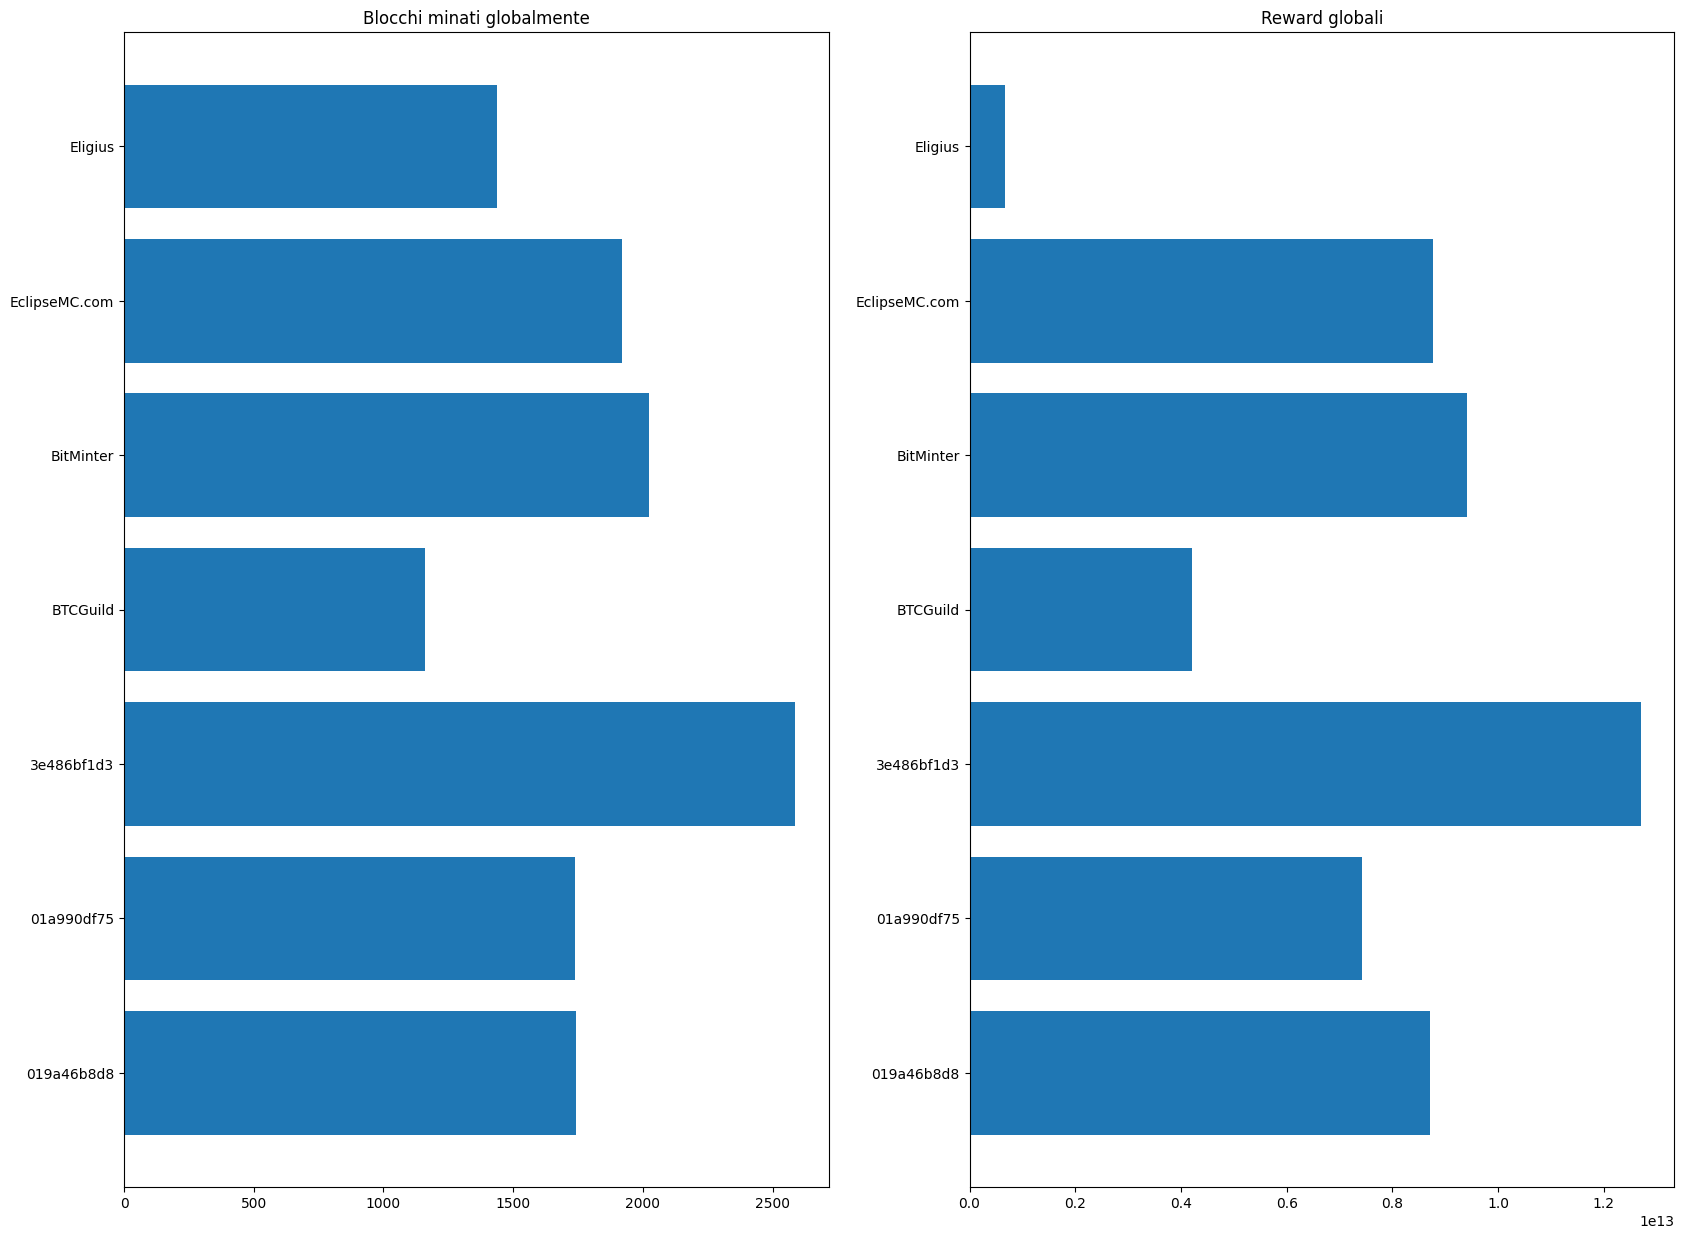

In [72]:
# analizzare le Coinbase deanonimizzate:
#   numero di blocchi minati sia globalmente, che mostrando l’andamento temporale dei blocchi minati, per intervalli temporali di due mesi
#   distribuzione delle reward totali ricevute da ogni mining pool, sia globalmente che mostrandone l'andamento temporale

interest_df = deanonymized_tx[deanonymized_tx['pool'] != 'Other']\
    .drop(columns=['txId', 'addressId', 'scriptType'])

nBlocks_grouped = interest_df.groupby('pool').agg({'blockId': 'size', 'amount': 'sum'})\
    .reset_index()
nBlocks_grouped.columns = ['pool', 'blockCount', 'totalAmount']


# controllo: non si sono perse righe
assert nBlocks_grouped['blockCount'].sum() == len(interest_df.index)
assert nBlocks_grouped['totalAmount'].sum() == interest_df['amount'].sum()

#print(nBlocks_grouped)

nBlocks_grouped = nBlocks_grouped.replace('EclipseMC.com-old', 'EclipseMC.com')
#print(nBlocks_grouped)


rows = nBlocks_grouped['pool'].unique().size

figBar, axsBar = plt.subplots(1, 2, figsize=(20, 15))
axsBar[0].barh(nBlocks_grouped['pool'], nBlocks_grouped['blockCount'])
axsBar[0].set_title('Blocchi minati globalmente')

axsBar[1].barh(nBlocks_grouped['pool'], nBlocks_grouped['totalAmount'])
axsBar[1].set_title('Reward globali')

''' statistiche globali
             pool  blockCount     totalAmount
       019a46b8d8        1741   8713619305387
       01a990df75        1738   7416681029411
       3e486bf1d3        2587  12696869155524
         BTCGuild        1162   4203649145799
        BitMinter        2024   9413281313194
    EclipseMC.com        1919   8772777983863
          Eligius        1439    671414768803
'''

            pool  blockCount     totalAmount
0     019a46b8d8        1741   8713619305387
1     01a990df75        1738   7416681029411
2     3e486bf1d3        2587  12696869155524
3       BTCGuild        1162   4203649145799
4      BitMinter        2024   9413281313194
5  EclipseMC.com        1919   8772777983863
6        Eligius        1439    671414768803


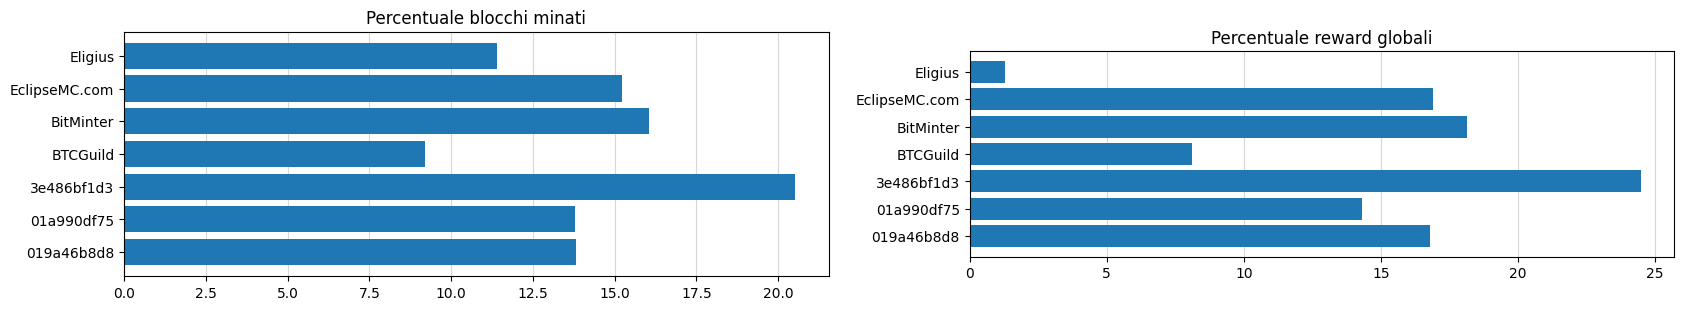

In [73]:
#H chart
print(nBlocks_grouped)

total_block = nBlocks_grouped['blockCount'].sum()
total_amount = nBlocks_grouped['totalAmount'].sum()

nBlocks_grouped_pcg = nBlocks_grouped.drop(columns=['blockCount', 'totalAmount'])
nBlocks_grouped_pcg['blockPct'] = (nBlocks_grouped['blockCount'] / total_block) * 100
nBlocks_grouped_pcg['amountPct'] = (nBlocks_grouped['totalAmount'] / total_amount) * 100


figH, axsH = plt.subplots(1, 2, figsize=(20, 15))

axsH[0].grid(axis='x', alpha=0.5, zorder=0)
axsH[0].barh(nBlocks_grouped_pcg['pool'], nBlocks_grouped_pcg['blockPct'], zorder=2)
axsH[0].set_title('Percentuale blocchi minati')
axsH[0].set_aspect('equal')

axsH[1].grid(axis='x', alpha=0.5, zorder=0)
axsH[1].barh(nBlocks_grouped_pcg['pool'], nBlocks_grouped_pcg['amountPct'], zorder=2)
axsH[1].set_title('Percentuale reward globali')
axsH[1].set_aspect('equal')


<Figure size 640x480 with 0 Axes>

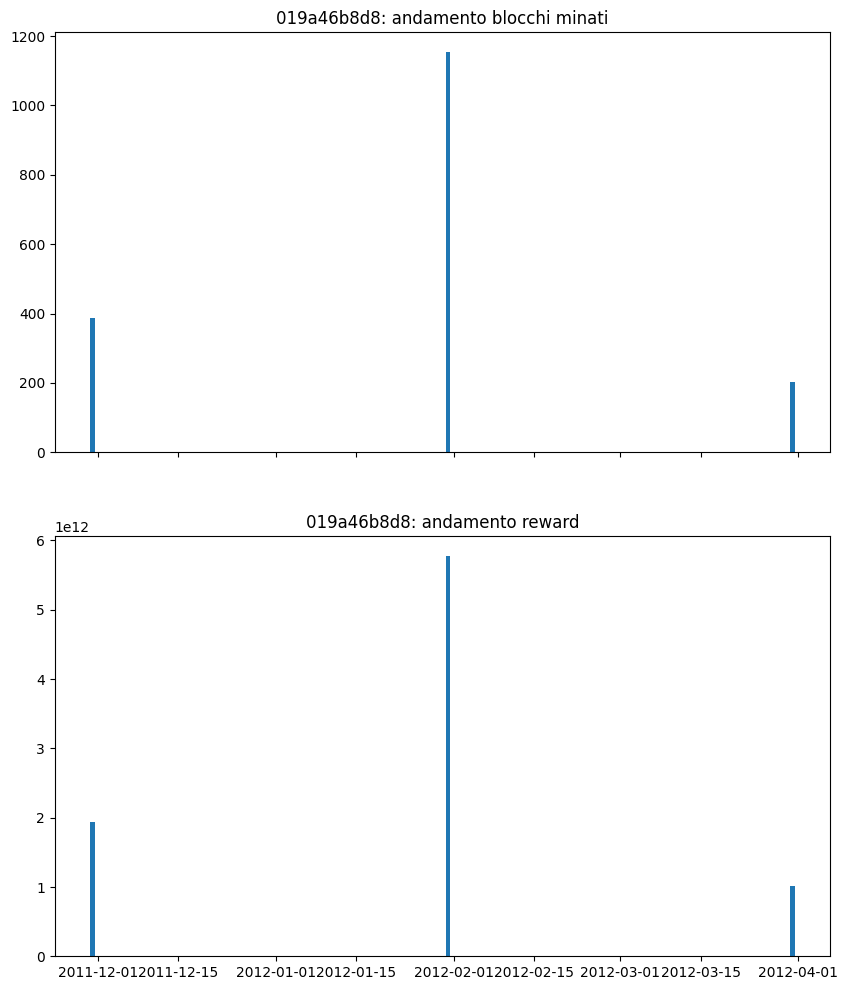

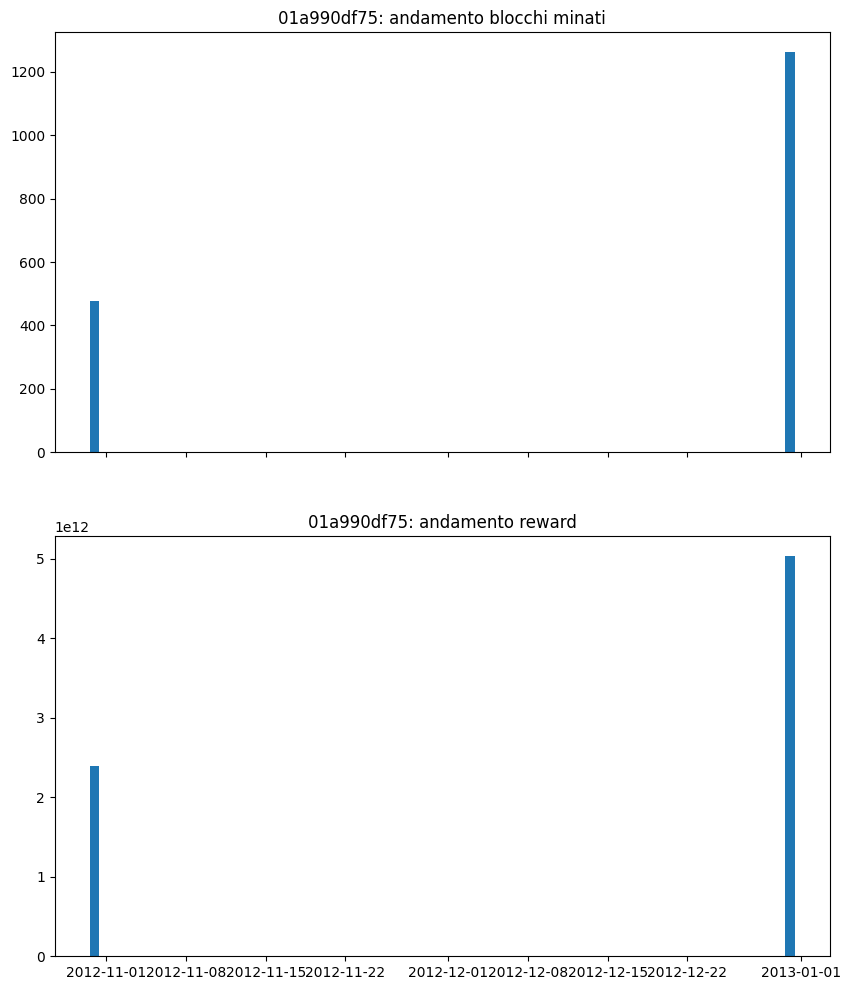

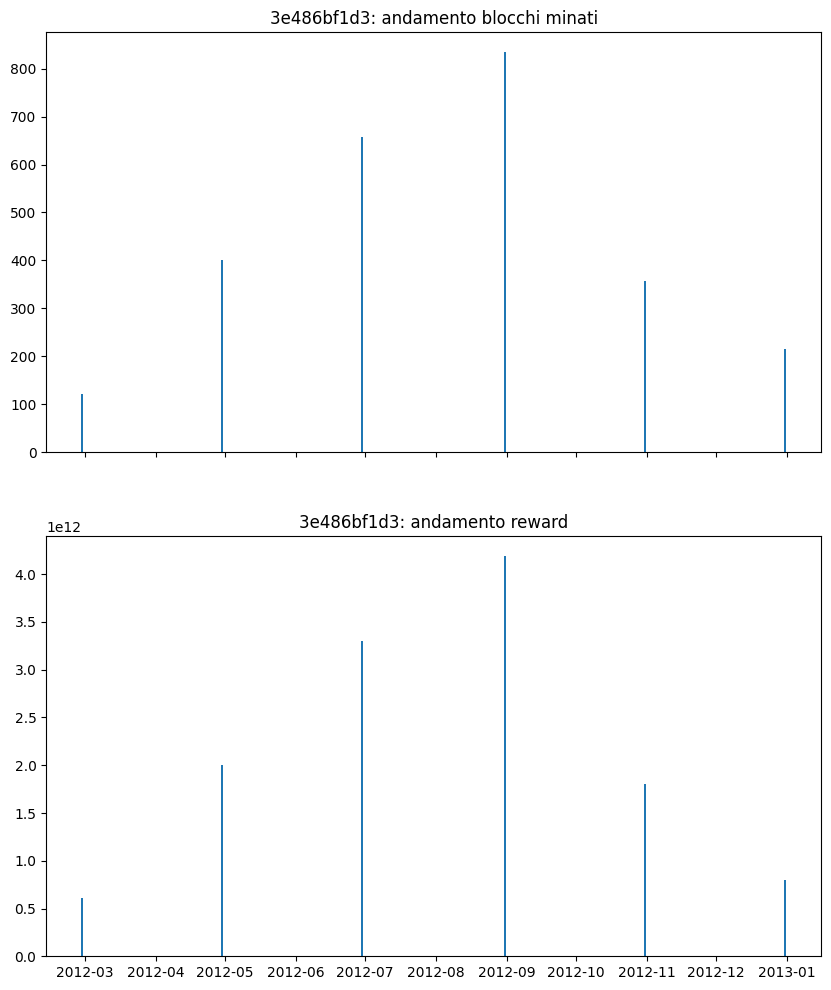

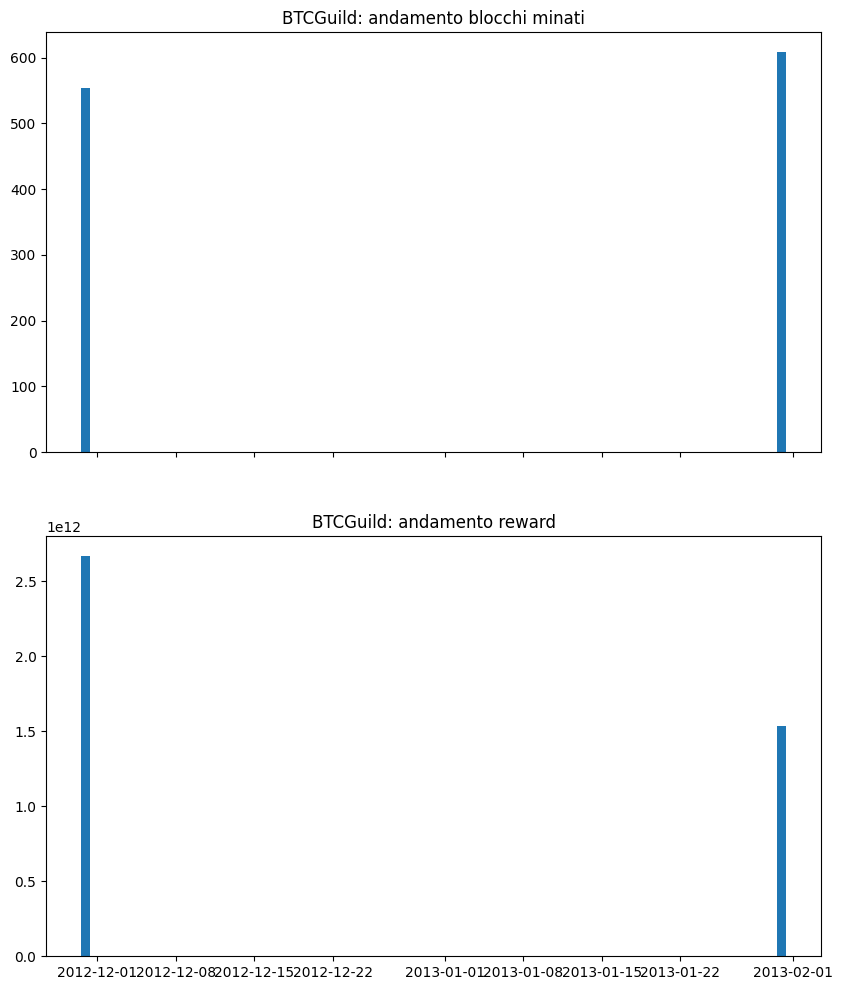

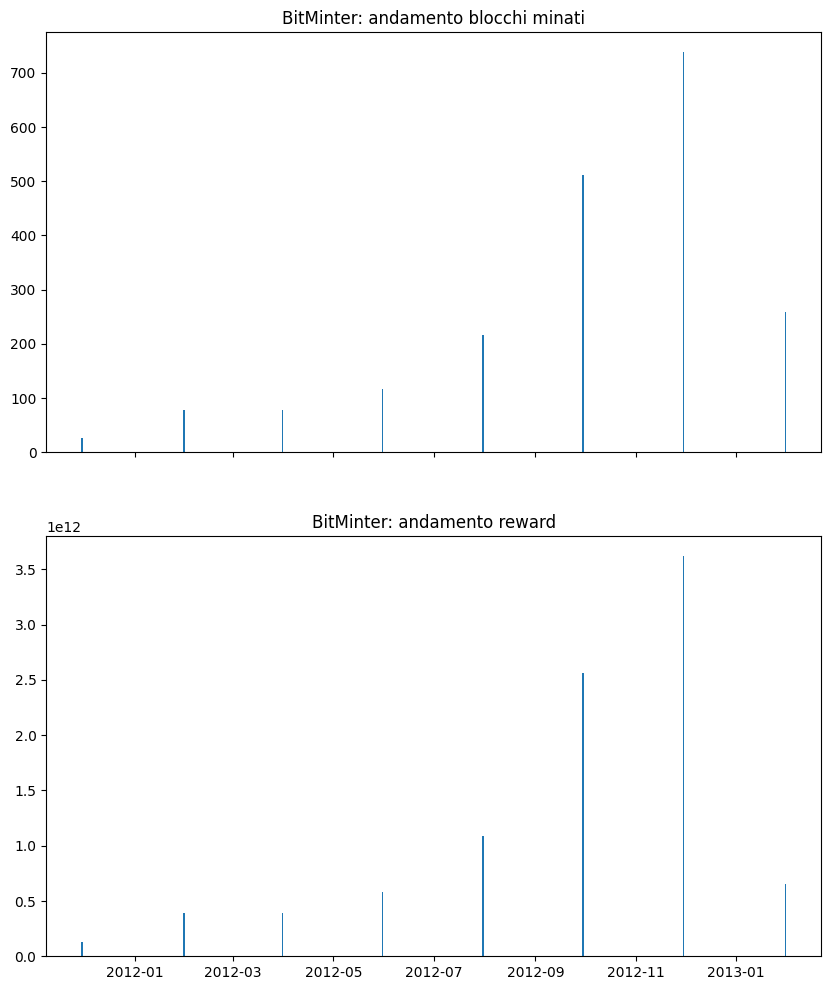

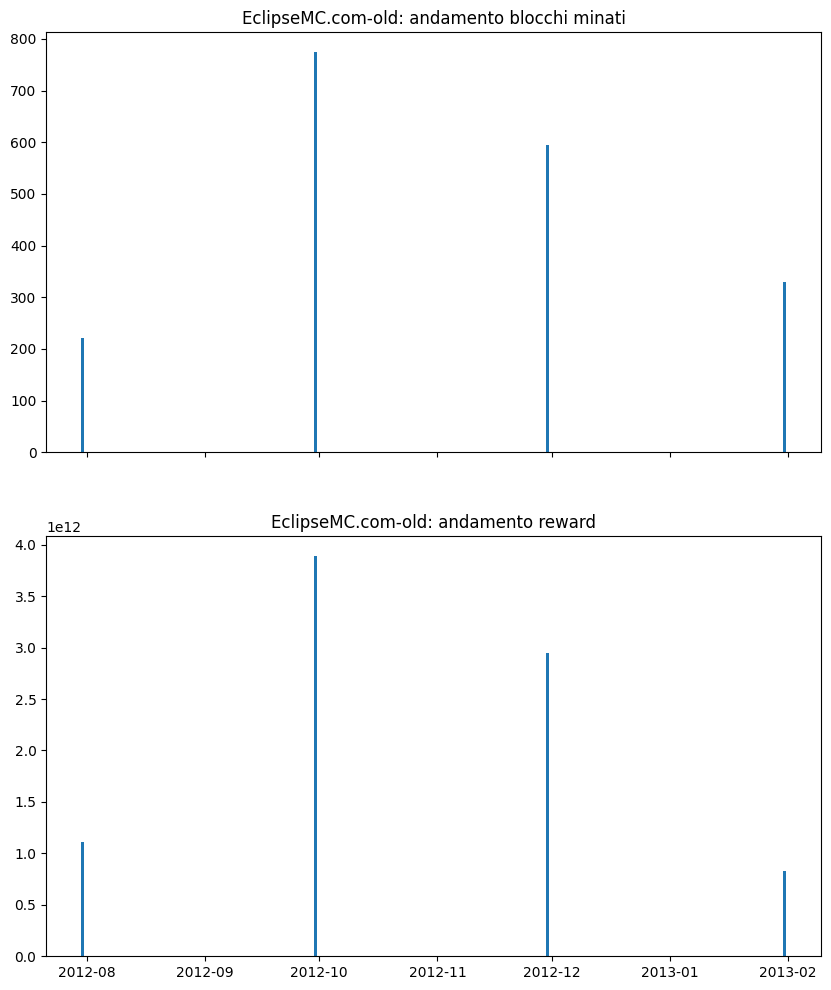

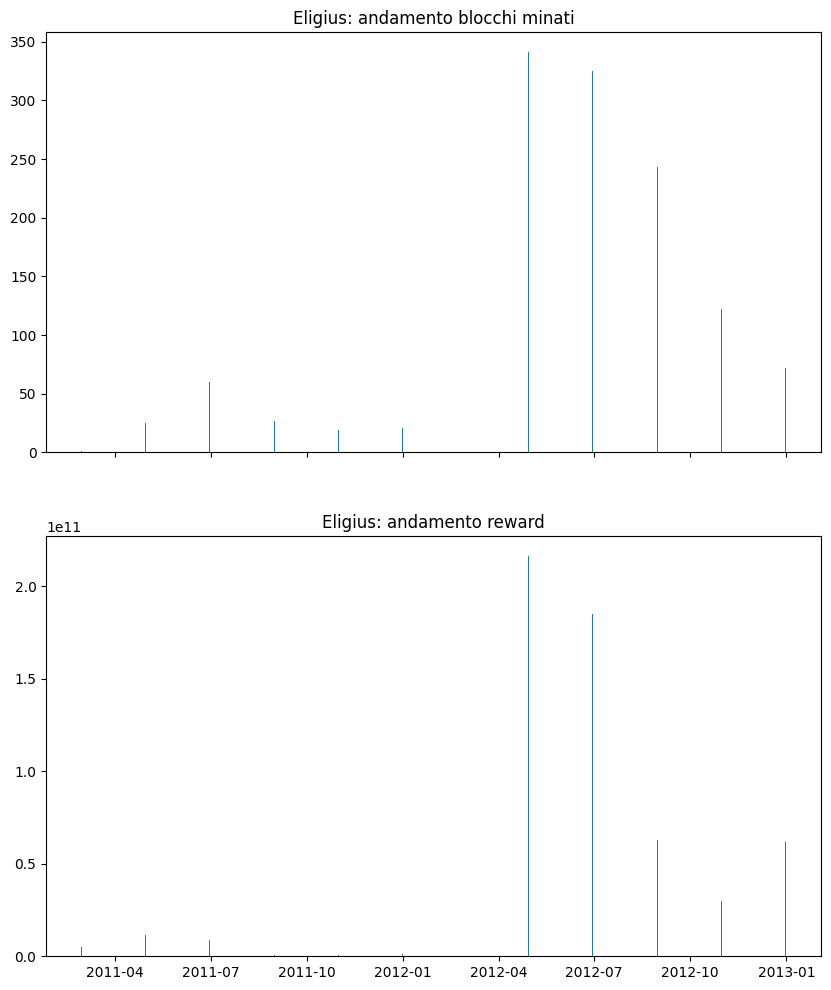

In [32]:
interest_df['timestamp'] = pd.to_datetime(interest_df['timestamp'], unit='s')

rows = nBlocks_grouped['pool'].unique().size
#fig, axs = plt.subplots(rows, 2, figsize=(10, 12), sharex=True)
plt.subplots_adjust(hspace=0.5)

i = 0
for p in nBlocks_grouped['pool']:
    df = interest_df[interest_df['pool'] == p]\
        .drop(columns=['pool'])\
        .resample('2ME', on='timestamp')\
        .agg({'blockId': 'count', 'amount': 'sum'}).reset_index()
    
    df.columns = ['timestamp', 'blockCount', 'totalAmount']
    
    #assert df['totalAmount'] == nBlocks_grouped[nBlocks_grouped['pool'] == p]
    #print(p)
    #print(df)

    fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    axs[0].bar(df['timestamp'], df['blockCount'])
    axs[0].set_title(f'{p}: andamento blocchi minati')

    axs[1].bar(df['timestamp'], df['totalAmount'])
    axs[1].set_title(f'{p}: andamento reward')
        
    '''axs[i, 0].bar(df['timestamp'], df['blockCount'])
    axs[i, 0].set_title(f'{p}: andamento blocchi minati')
    axs[i, 0].set_yscale('log')

    axs[i, 1].bar(df['timestamp'], df['totalAmount'])
    axs[i, 1].set_title(f'{p}: andamento reward')'''

    #i += 1

    
plt.show()